## Sentiment Analysis

##### Improvement

1. Refactor and modularize helper functions and import it from utils
2. Use pre-trained word embeddings
3. Build vocab smartly

In [1]:
import pandas as pd
import numpy as np
import torch

import matplotlib.pyplot as plt
import seaborn as sns

from utils import preprocess_text, pad_sequence, train_test_split_tensors, train_model

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Neeraj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Neeraj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Neeraj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Data preparation

#### Load the dataset

In [2]:
train = pd.read_csv("../data/IMDB Sentiment Analysis/Train.csv")
test = pd.read_csv("../data/IMDB Sentiment Analysis/Test.csv")
val = pd.read_csv("../data/IMDB Sentiment Analysis/Valid.csv")

In [3]:
df_all = pd.concat([train, val, test], axis=0)

In [4]:
df_all.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [5]:
dataset_size = len(df_all)
dataset_size

50000

#### Preprocess Dataset

In [6]:
df_all["word_list"] = df_all["text"].apply(lambda text: preprocess_text(text))

In [7]:
df_all.head()

,text,label,word_list
0,I grew up (b. 1965) watching and loving the Th...,0,"[grew, b, watching, loving, thunderbird, mate,..."
1,"When I put this movie in my DVD player, and sa...",0,"[put, movie, dvd, player, sat, coke, chip, exp..."
2,Why do people who do not know what a particula...,0,"[people, know, particular, time, past, like, f..."
3,Even though I have great interest in Biblical ...,0,"[even, though, great, interest, biblical, movi..."
4,Im a die hard Dads Army fan and nothing will e...,1,"[im, die, hard, dad, army, fan, nothing, ever,..."


In [8]:
df_all["word_count"] = df_all["word_list"].apply(lambda word_list: len(word_list))

<Figure size 1152x576 with 0 Axes>

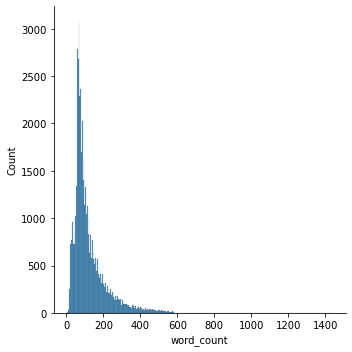

In [9]:
plt.figure(figsize=(16, 8))
sns.displot(df_all["word_count"])

In [10]:
print(f"mean: {df_all['word_count'].mean()} \
        median: {df_all['word_count'].median()} \
        std: {df_all['word_count'].std()} \
        max: {df_all['word_count'].max()} \
        min: {df_all['word_count'].min()}")

mean: 121.2643         median: 90.0         std: 91.36838495423598         max: 1438         min: 3


In [11]:
max_sequence_length = int(df_all['word_count'].median() + 2 * df_all['word_count'].std())
max_sequence_length

272

#### Build Vocab

In [12]:
all_words_list = []
df_all["word_list"].apply(lambda word_list: all_words_list.extend(word_list))

0       None
1       None
2       None
3       None
4       None
        ... 
4995    None
4996    None
4997    None
4998    None
4999    None
Name: word_list, Length: 50000, dtype: object

##### Get frequency of the words

In [13]:
from collections import Counter

In [14]:
word_frequency = Counter(all_words_list)

In [15]:
print(f"mean: {np.mean(list(word_frequency.values()))} \
        median: {np.median(list(word_frequency.values()))} \
        std: {np.std(list(word_frequency.values()))} \
        max: {max(word_frequency.values())} \
        min: {min(word_frequency.values())}")

mean: 40.14523412257005         median: 1.0         std: 639.2531565816863         max: 114803         min: 1


We can see that there is a huge standard deviation

For Convinience we'll take the min_frequency of the word to appear in the vocabulary as 20

In [16]:
min_frequency = 20

In [17]:
new_word_frequency = {word: freq for word, freq in word_frequency.items() if freq > min_frequency}

In [18]:
len(new_word_frequency)

17018

#### Load GloVe Vectors

In [19]:
import os

In [20]:
glove_dir = "../data/glove.6B/"

In [21]:
embedding_mapping = {}

In [22]:
with open(os.path.join(glove_dir, "glove.6B.100d.txt"), "r", encoding="utf-8") as f:
    for line in f.readlines():
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        embedding_mapping[word] = coeffs

##### Create Embedding Matrix

In [23]:
vocab_size = len(new_word_frequency)
embedding_dim = 100

In [24]:
embedding_matrix = torch.randn((vocab_size + 2, embedding_dim), dtype=torch.float32)

In [25]:
embedding_matrix[0] = torch.zeros(embedding_dim) # making the padding idx zero

##### Create Word2Idx

In [26]:
word2idx = {word: idx + 2 for idx, word in enumerate(new_word_frequency)}

##### Populate embedding matrix

In [27]:
rare_words = [] # words not in embedding
for word, idx in word2idx.items():
    vector = embedding_mapping.get(word)
    if vector is None:
        rare_words.append(word)
        continue
    tensor = torch.from_numpy(vector)
    embedding_matrix[idx] = tensor

In [28]:
len(rare_words)

435

Only 435 words do not have a pretrained embedding, which is good

#### Preparing data for training

##### Converting words to indices

In [29]:
unk_idx = 1

In [30]:
df_all["word_indices"] = df_all["word_list"].apply(lambda word_list: [word2idx.get(word, unk_idx) for word in word_list])

In [31]:
df_all["padded_word_indices"] = df_all["word_indices"].apply(lambda word_index_list: pad_sequence(word_index_list, max_sequence_length))

In [32]:
n_sequences = len(df_all)

In [33]:
all_data = np.zeros((n_sequences, max_sequence_length), dtype=np.int64)
for i, _list in enumerate(df_all["padded_word_indices"]):
    all_data[i] = np.asarray(_list)

In [34]:
len(df_all["word_list"])

50000

In [35]:
all_labels = df_all["label"].values

##### Splitting the data and loading into a dataloader

In [36]:
train_dataloader, test_dataloader = train_test_split_tensors(all_data, all_labels)

Data Split in the following way:
X train: (40000, 272)
 X test: (10000, 272) 
 Y train: (40000,)
 Y test: (10000,)
Creating dataloaders...
Done


### Building the Model

In [37]:
import torch.nn as nn

In [38]:
class LinearClassifier(nn.Module):
    def __init__(self, VOCAB_SIZE, EMBEDDING_DIM, SEQUENCE_LENGTH, weights):
        super().__init__()
        self.EMBEDDING_DIM = EMBEDDING_DIM
        self.SEQUENCE_LENGTH = SEQUENCE_LENGTH
        self.embedding = nn.Embedding(VOCAB_SIZE + 2, EMBEDDING_DIM, padding_idx=0, _weight = weights)
        self.linear1 = nn.Linear(EMBEDDING_DIM * SEQUENCE_LENGTH, 64)
        self.linear2 = nn.Linear(64, 2)
        
    def forward(self, inputs):
        embedding_vectors = self.embedding(inputs)
        flattened_embeddings = embedding_vectors.view(-1, self.EMBEDDING_DIM * self.SEQUENCE_LENGTH)
        out = torch.tanh(self.linear1(flattened_embeddings))
        out = self.linear2(out)
        
        return out

In [39]:
model = LinearClassifier(vocab_size, embedding_dim, max_sequence_length, embedding_matrix)

### Training the model

In [40]:
import torch.optim as optim

In [41]:
loss = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=1e-3)
n_epochs = 50

In [42]:
device = torch.device('cuda') 

In [43]:
model.to(device=device)

LinearClassifier(
  (embedding): Embedding(17020, 100, padding_idx=0)
  (linear1): Linear(in_features=27200, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=2, bias=True)
)

In [44]:
train_acc_list, val_acc_list, train_loss_list, val_loss_list = train_model(n_epochs, model, train_dataloader, test_dataloader, loss, optimizer, device)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [07:22<00:00,  8.85s/it]


##### Plot loss

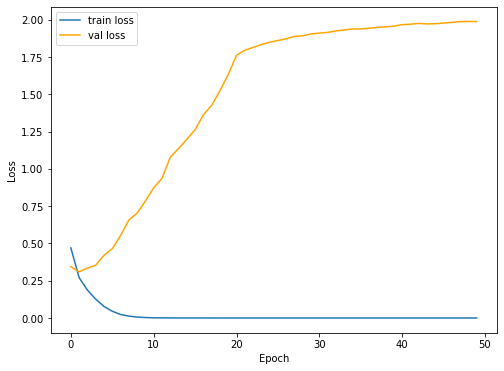

In [45]:
fig, axes = plt.subplots(1, 1, figsize=(8, 6))

axes.plot(list(range(n_epochs)), train_loss_list, label="train loss")
axes.plot(list(range(n_epochs)), val_loss_list, color='orange', label="val loss")

axes.set_xlabel("Epoch")
axes.set_ylabel("Loss")

plt.legend()

##### Plot accuracy

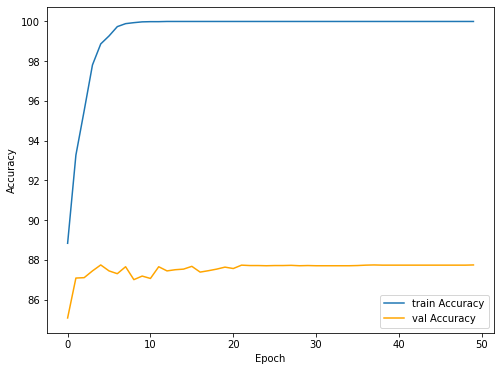

In [46]:
fig, axes = plt.subplots(1, 1, figsize=(8, 6))

axes.plot(list(range(n_epochs)), train_acc_list, label="train Accuracy")
axes.plot(list(range(n_epochs)), val_acc_list, color='orange', label="val Accuracy")

axes.set_xlabel("Epoch")
axes.set_ylabel("Accuracy")

plt.legend()

### Thoughts

1. Even with pre-trained embeddings, we didn't do much better than the previous time where we didn't use any. Reasons:
   - the dataset was sufficiently big in our case
   - This tells us to use pretrained embeddings when the dataset is small
2. Also observe that the model is not able generalize i.e the validation accuracy doesn't go beyond a certain point while the training accuracy is high. Reasons for this:
   - We are using a linear model which treats each word independently, and hence it's not able to find the context in the sentence, and hence it tries to memorize the sentences.
   - What this means is that the model cannot recognize similar but not exact sentences. example: The sentences 'I'm going to bed' and 'I'm sleeping on bed' are totally different to the model even though they mean the same thing
   - There are lots of parameters in the model which make the model memorize the training data, hence the training accuracy is high.